In [ ]:
!unzip gdrive/My\ Drive/WCD-ML/archive.zip -d "/content/lung_cancer"

In [ ]:
#Define Directories for train, test & Validation Set
train_path = '/content/lung_cancer/Data/train'
test_path = '/content/lung_cancer/Data/test'
valid_path = '/content/lung_cancer/Data/valid'

In [ ]:
train_path

'/content/lung_cancer/Data/train'

FAST AI


In [ ]:
from fastai.vision.all import *
import pandas as pd
from PIL import Image, ImageEnhance
from pathlib import Path

In [ ]:
cwd = Path('/content/lung_cancer/Data/train')
fnames = get_image_files(cwd)
fnames[0]

Path('/content/lung_cancer/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000067 (5).png')

In [ ]:
# Get the label from the parent of each image filename
df = pd.DataFrame()
for fname in fnames:
    df = df.append({'fname':fname, 'label': fname.parent.name}, ignore_index=True)
df.head()

,fname,label
0,/content/lung_cancer/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000067 (5).png,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
1,/content/lung_cancer/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000104 (2).png,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
2,/content/lung_cancer/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000004 (4).png,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
3,/content/lung_cancer/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000084 (5).png,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
4,/content/lung_cancer/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/sq3.png,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [ ]:
# This leads to an imbalance in the data, so let's just take a sample
df.label = df.label.replace({'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib':'adenocarcinoma',
                             'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa':'large_cell_carcinoma',
                             'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa':'squamous_cell_carcinoma'})
df.label.value_counts()

adenocarcinoma             194
squamous_cell_carcinoma    153
normal                     146
large_cell_carcinoma       113
Name: label, dtype: int64

In [ ]:
# Taking a sample of the data also allows for faster prototyping

# Get a list of the labels
labels = df.label.unique()

# Size of our samples
sample_size = 110

# New dataframe
sampled_df = pd.DataFrame()
for label in labels:
    sampled_df = sampled_df.append(df[df.label==label].sample(sample_size))

# Replace our dataframe with the sampled version
df = sampled_df

#Let's look at the label distribution
df.label.value_counts()

squamous_cell_carcinoma    110
normal                     110
large_cell_carcinoma       110
adenocarcinoma             110
Name: label, dtype: int64

In [ ]:
#batch size
bs = 50
# vvg16 takes 224x224 
dls = ImageDataLoaders.from_df(df, path='/', bs=bs, batch_tfms=[*aug_transforms(),
                                                                Normalize.from_stats(*imagenet_stats)], 
                               item_tfms=[Resize(224, method='squish')])
dls.vocab

['adenocarcinoma', 'large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma']

In [ ]:
#  used squeezenet and vgg 16 as the base model,vgg16 has better accuracy
learn = cnn_learner(dls, models.vgg16_bn, metrics=accuracy)


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Choose the number of epochs
epochs = 10
learn.fine_tune(epochs)

epoch,train_loss,valid_loss,accuracy,time
0,2.075650,1.364550,0.375000,08:12


epoch,train_loss,valid_loss,accuracy,time
0,1.271657,1.060362,0.522727,12:00
1,1.096923,0.897568,0.647727,11:50
2,0.901024,0.688326,0.761364,11:58
3,0.748183,0.506316,0.795455,12:21
4,0.630399,0.476170,0.818182,12:18
5,0.539173,0.468034,0.852273,12:18
6,0.460236,0.404028,0.863636,12:20
7,0.405243,0.375020,0.875000,11:52
8,0.351159,0.365272,0.863636,11:53


epoch,train_loss,valid_loss,accuracy,time
0,1.271657,1.060362,0.522727,12:00
1,1.096923,0.897568,0.647727,11:50
2,0.901024,0.688326,0.761364,11:58
3,0.748183,0.506316,0.795455,12:21
4,0.630399,0.476170,0.818182,12:18
5,0.539173,0.468034,0.852273,12:18
6,0.460236,0.404028,0.863636,12:20
7,0.405243,0.375020,0.875000,11:52
8,0.351159,0.365272,0.863636,11:53


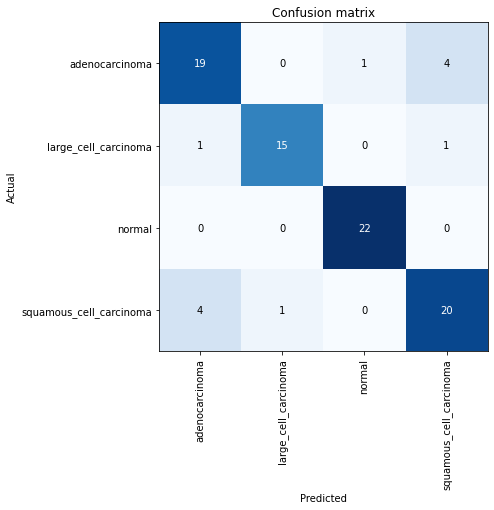

In [ ]:
# Use the ClassificationInterpretation class to get the top_losses

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

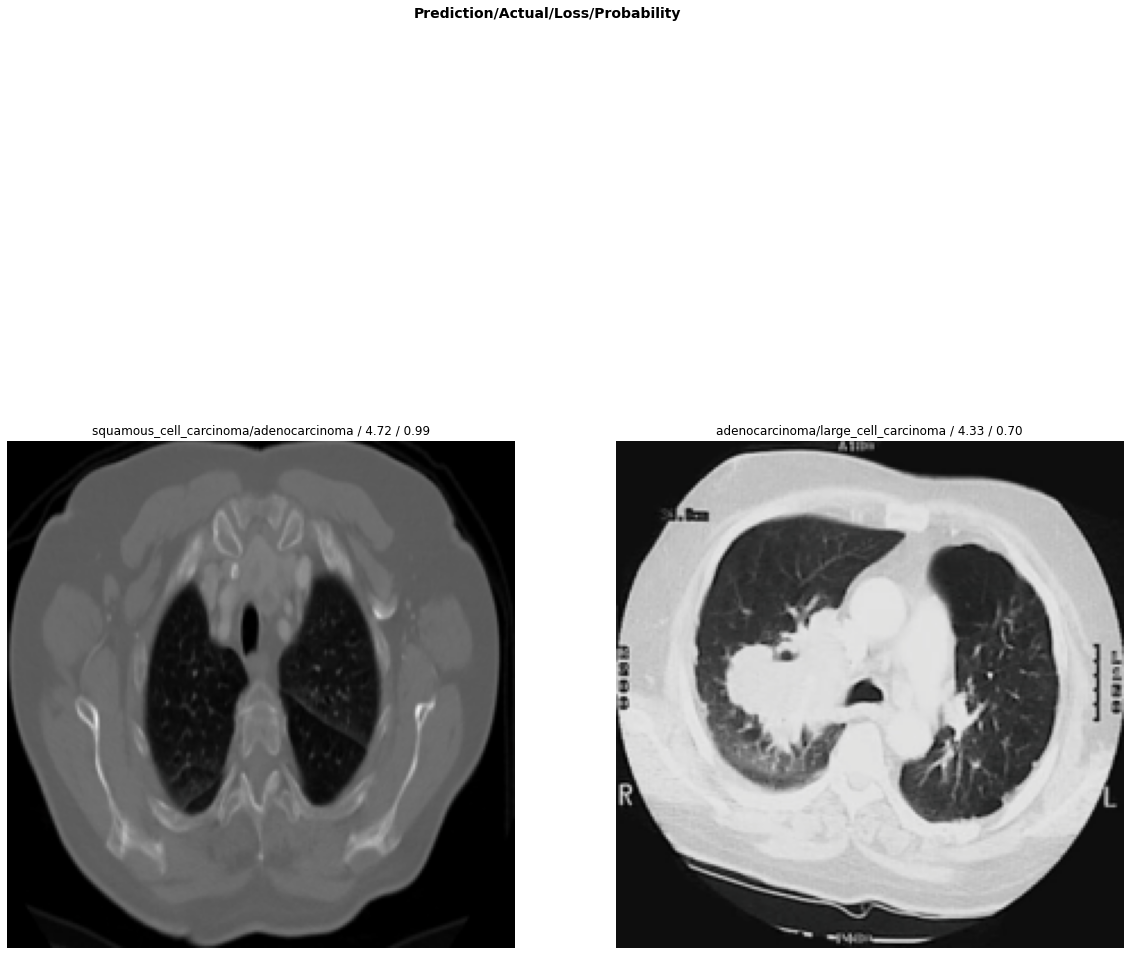

In [ ]:
# View top losses
interp.plot_top_losses(k=2, figsize=(20,20))